In [1]:
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor, Ensemble, MCDropout
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
sns.set(font_scale=0.75)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt

In [8]:
device= torch.device("cuda")
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5), torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x), (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(0.5 + sep, 1 + sep)), 0)
        x = torch.cat((x, torch.zeros(32, 1).uniform_(0.5, 1.5)), 0)
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(16, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(16, 1).uniform_(2, 2.25)), 0)
#         ood_x = torch.cat((ood_x, torch.zeros(64, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data(1024)
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)

In [ ]:
device= torch.device("cuda")
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)
density_estimator = CVKernelDensityEstimator()
additional_data = {'train_Y_2': y2,
                  'ood_X': ood_x,
                  'ood_Y': ood_y}
networks = {'a_predictor': create_network(1, 1, 32, 'tanh', True),
            'e_predictor': create_network(2, 1, 1024, 'relu', True, 4),
            'f_predictor': create_network(1, 1, 512, 'relu', False, 3)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-4),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-4)
              }
# schedulers = {'e_scheduler': create_multiplicative_scheduler(optimizers['e_optimizer'],
#                                                             lr_schedule=0.999)
# }
model = EpistemicPredictor(train_X=x,
                           train_Y=y,
                           networks=networks,
                           optimizers=optimizers,
                           density_estimator=density_estimator,
                           train_Y_2=y2,
                           ood_X=ood_x,
                           ood_Y=ood_y,
                           batch_size=64,
                           retrain=False,
                           device=device)


In [ ]:
model.pretrain_density_estimator(x)

In [ ]:
device = torch.device("cpu")
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)
plt.scatter(x, y, color='b', s=1, label='in domain data')
plt.scatter(ood_x, ood_y, color='g', s=.5, label='ood data')
plt.plot(x_test, density_estimator.score_samples(x_test))
plt.legend()
plt.show()


In [ ]:
device = torch.device("cuda")
model = model.to(device)

epochs = 350
losses = {'a': [], 'e': [], 'f': []}

for i in range(epochs):
    new_losses = model.fit()
    for key in 'af':
        losses[key].extend(new_losses[key])
    print(i, losses['f'][-1])

In [ ]:
device = torch.device("cuda")
model = model.to(device)

epochs = 200
for i in range(epochs):
    new_losses = model.fit_ood()
    for key in 'e':
        losses[key].extend(new_losses[key])
    print(i, losses['e'][-1])

In [ ]:
plt.plot(losses['f'], label='f_loss')
plt.plot(losses['a'], label='a_loss')
plt.plot(losses['e'], label='u_loss')
plt.legend()
plt.show()

In [ ]:
device = torch.device("cpu")
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)
model = model.to(device)

In [ ]:
predictions = networks['f_predictor'](x_test).detach().numpy().ravel()

In [ ]:
plt.figure(figsize=(10, 6))

# aleatoric_u = networks['a_predictor'](x_test).detach().numpy().ravel()
# a_low = predictions - np.sqrt(aleatoric_u)
# a_high = predictions + np.sqrt(aleatoric_u)

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.5)
plt.plot(x, y, '.', label='train_samples', alpha=.5)
plt.plot(x_test, predictions, label='predictions', alpha=.3, lw=2)
# plt.fill_between(x_test.numpy().ravel(), a_low, a_high, alpha=.3, label='aleatoric')

test_den = torch.FloatTensor(density_estimator.score_samples(x_test.numpy()).reshape(-1, 1))
e_in = torch.cat((x_test.view(-1, 1), test_den), axis=1)
epistemic_u = networks['e_predictor'](e_in).detach().numpy().ravel()

e_low = predictions - np.sqrt(epistemic_u)
e_high = predictions + np.sqrt(epistemic_u)

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (networks['f_predictor'](x_test) - y_test).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = predictions - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = predictions + np.sqrt(exp_epistemic_uncertainty)

plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.legend()
plt.show()

# total_uncertainty = epistemic_u + aleatoric_u


In [ ]:
# plt.plot(x_test, exp_total_uncertainty, label='true total uncertainty')
# plt.plot(x_test, total_uncertainty, label='predicted total uncertainty')
# plt.legend()
# plt.show()

In [ ]:
plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
plt.legend()
plt.show()

In [ ]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [88]:
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5), torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x), (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(0.5 + sep, 1 + sep)), 0)
        x = torch.cat((x, torch.zeros(128, 1).uniform_(0.5, 1.5)), 0)
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(16, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(16, 1).uniform_(2, 2.25)), 0)
#         ood_x = torch.cat((ood_x, torch.zeros(64, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data(1024)
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)

In [89]:
model = SingleTaskGP(x, y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

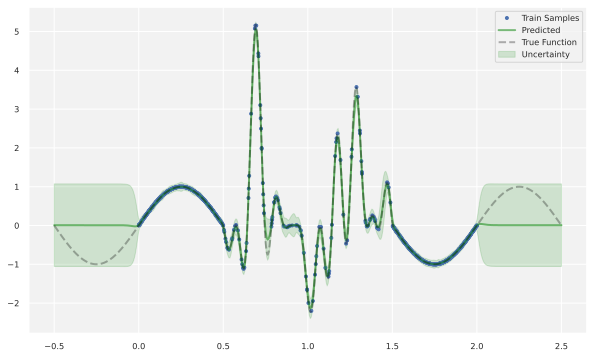

In [90]:
y_preds = model(x_test)

plt.figure(figsize=(10, 6))

plt.plot(x, y, '.', label='Train Samples', alpha=1)
plt.plot(x_test, y_preds.mean.detach(), label='Predicted', alpha=.5, lw=2, color="green")
plt.plot(x_test, y_test, '--', label='True Function', color="black", lw=2, alpha=.3)


e_low = (y_preds.mean - y_preds.stddev).detach()
e_high = (y_preds.mean + y_preds.stddev).detach()

exp_e_low = y_preds.mean.detach() - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = y_preds.mean.detach() + np.sqrt(exp_epistemic_uncertainty)

# plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.15, label='Uncertainty', color="green")

exp_epistemic_uncertainty = (y_preds.mean.detach() - y_test.squeeze()).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!



plt.legend()
plt.show()

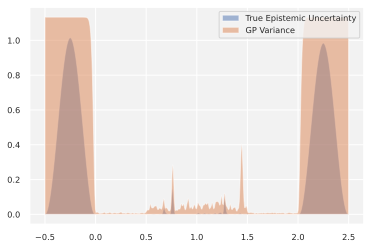

In [91]:
# plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
# plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
plt.fill_between(x_test.view(-1).numpy(), exp_epistemic_uncertainty, 0, alpha=0.5, label='True Epistemic Uncertainty')
plt.fill_between(x_test.view(-1).numpy(), y_preds.variance.detach(), 0, alpha=0.5, label='GP Variance')
plt.legend()
plt.show()

In [65]:
device = torch.device("cuda")
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5), torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x), (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(0.5 + sep, 1 + sep)), 0)
        x = torch.cat((x, torch.zeros(128, 1).uniform_(0.5, 1.5)), 0)
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(16, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(16, 1).uniform_(2, 2.25)), 0)
#         ood_x = torch.cat((ood_x, torch.zeros(64, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data(1024)
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)

In [66]:
num_members = 5

networks = [create_network(1, 1, 512, 'relu', False, 3) for _ in range(num_members)]
optimizers = [create_optimizer(networks[i], 1e-3) for i in range(num_members)]

In [67]:
device = torch.device("cuda")
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)
# model = model.to(device)

In [68]:
model = Ensemble(x, y, networks=networks, optimizers=optimizers, batch_size=32)
model = model.to(device)
for i in range(500):
    if i % 50==0:
        print(i)
    model.fit()

0
50
100
150
200
250
300
350
400
450


In [69]:
device = torch.device("cpu")
x, y, y2, x_test, y_test, ood_x, ood_y = x.to(device), y.to(device), y2.to(device), x_test.to(device), y_test.to(device), ood_x.to(device), ood_y.to(device)
model = model.to(device)

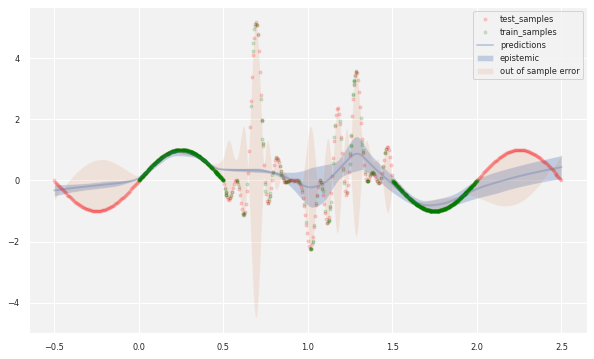

In [70]:
y_preds = model(x_test)

plt.figure(figsize=(10, 6))

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15, color='red')
plt.plot(x, y, '.', label='train_samples', alpha=.15, color='green')
plt.plot(x_test, y_preds.mean.detach(), label='predictions', alpha=.3, lw=2)

e_low = (y_preds.mean - y_preds.stddev).detach().squeeze()
e_high = (y_preds.mean + y_preds.stddev).detach().squeeze()

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (y_preds.mean.detach().squeeze() - y_test.squeeze()).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = y_preds.mean.detach().squeeze() - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = y_preds.mean.detach().squeeze() + np.sqrt(exp_epistemic_uncertainty)

plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.legend()
plt.show()

In [59]:
exp_e_low.shape, e_high.shape

(torch.Size([512]), torch.Size([512]))

In [ ]:
(y_preds.mean.detach().squeeze() - y_test.squeeze()).shape

In [ ]:
lengthscale = 1e-2
tau = 0.5
dropout_prob = 0.1
# density_estimator = FixedKernelDensityEstimator('exponential', 0.05)
#torch.manual_seed(8)
networks = {
    'f_predictor': create_network(1, 1, 128, 'relu', False, dropout_prob)
}

optimizers = {'f_optimizer': create_optimizer(networks['f_predictor'], 0.001)}

In [ ]:
reg = lengthscale ** 2 * (1 - dropout_prob) / (2. * x.size(0) * tau)
optimizers['f_optimizer'] = create_optimizer(networks['f_predictor'], 0.001,
                                                                weight_decay=reg,
                                                                output_weight_decay=reg)

In [ ]:
model = MCDropout(x, y, network=networks['f_predictor'], optimizer=optimizers['f_optimizer'], batch_size=32)
for _ in range(1000):
    model.fit()

In [ ]:
y_preds = model(x_test)

plt.figure(figsize=(10, 6))

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15, color='red')
plt.plot(x_test, y_preds.mean.detach(), label='predictions', alpha=.3, lw=2)

e_low = (y_preds.mean - y_preds.stddev).detach().squeeze()
e_high = (y_preds.mean + y_preds.stddev).detach().squeeze()

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (y_preds.mean.detach().squeeze() - y_test.squeeze()).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = y_preds.mean.detach().squeeze() - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = y_preds.mean.detach().squeeze() + np.sqrt(exp_epistemic_uncertainty)

plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.legend()
plt.show()